In [2]:
import os
import sys
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
matplotlib.style.use("Solarize_Light2")
%matplotlib inline

In [3]:


telemetry = pd.read_csv('PdM_telemetry.csv')
errors = pd.read_csv('PdM_errors.csv')
maint = pd.read_csv('PdM_maint.csv')
failures = pd.read_csv('PdM_failures.csv')
machines = pd.read_csv('PdM_machines.csv')

### Veri Düzenleme Fonksiyonları

In [4]:

def check_null(df):
    """
    Returns percentage of rows containing missing data
    """
    return df.isna().sum() * 100/len(df)


def get_missing_dates(series, start_date, end_date, freq="D"):
    """
    Returns the dates which are missing in the series
    date_sr between the start_date and end_date
    
    series: Series consisting of date
    start_date: Start date in String format
    end_date: End date in String format
    """
    return pd.date_range(
        start=start_date, end=end_date, freq=freq).difference(series)


def check_duplicate(df, subset):
    """
    Returns if there are any duplicate rows in the DataFrame.
    
    df: DataFrame under consideration
    subset: Optional List of feature names based on which 
            duplicate rows are being identified. 
    """
    if subset is not None: 
        return df.duplicated(subset=subset, keep=False).sum()
    else:
        return df.duplicated(keep=False).sum()


def create_date_features(source_df, target_df, feature_name):
    '''
    Create new features related to dates
    
    source_df : DataFrame consisting of the timestamp related feature
    target_df : DataFrame where new features will be added
    feature_name : Name of the feature of date type which needs to be decomposed.
    '''
    target_df.loc[:, 'year'] = source_df.loc[:, feature_name].dt.year.astype('uint16')
    target_df.loc[:, 'month'] = source_df.loc[:, feature_name].dt.month.astype('uint8')
    target_df.loc[:, 'quarter'] = source_df.loc[:, feature_name].dt.quarter.astype('uint8')
    target_df.loc[:, 'weekofyear'] = source_df.loc[:, feature_name].dt.isocalendar().week.astype('uint8')
    
    target_df.loc[:, 'hour'] = source_df.loc[:, feature_name].dt.hour.astype('uint8')
    
    target_df.loc[:, 'day'] = source_df.loc[:, feature_name].dt.day.astype('uint8')
    target_df.loc[:, 'dayofweek'] = source_df.loc[:, feature_name].dt.dayofweek.astype('uint8')
    target_df.loc[:, 'dayofyear'] = source_df.loc[:, feature_name].dt.dayofyear.astype('uint8')
    target_df.loc[:, 'is_month_start'] = source_df.loc[:, feature_name].dt.is_month_start
    target_df.loc[:, 'is_month_end'] = source_df.loc[:, feature_name].dt.is_month_end
    target_df.loc[:, 'is_quarter_start']= source_df.loc[:, feature_name].dt.is_quarter_start
    target_df.loc[:, 'is_quarter_end'] = source_df.loc[:, feature_name].dt.is_quarter_end
    target_df.loc[:, 'is_year_start'] = source_df.loc[:, feature_name].dt.is_year_start
    target_df.loc[:, 'is_year_end'] = source_df.loc[:, feature_name].dt.is_year_end
    
    # This is of type object
    target_df.loc[:, 'month_year'] = source_df.loc[:, feature_name].dt.to_period('M')
    
    return target_df



### **Grafik Fonksiyonları**

In [5]:

def plot_boxh_groupby(df, feature_name, by):
    """
    Box plot with groupby
    
    df: DataFrame
    feature_name: Name of the feature to be plotted
    by: Name of the feature based on which groups are created
    """
    df.boxplot(column=feature_name, by=by, vert=False, 
                              figsize=(10, 6))
    plt.title(f'Distribution of {feature_name} by {by}')
    plt.show()
    

def plot_hist(df, feature_name, kind='hist', bins=100, log=True):
    """
    Plot histogram.
    
    df: DataFrame
    feature_name: Name of the feature to be plotted.
    """
    if log:
        df[feature_name].apply(np.log1p).plot(kind='hist', 
                                              bins=bins, 
                                              figsize=(15, 5), 
                                              title=f'Distribution of log1p[{feature_name}]')
    else:
        df[feature_name].plot(kind='hist', 
                              bins=bins, 
                              figsize=(15, 5), 
                              title=f'Distribution of {feature_name}')
    plt.show()


    

def plot_ts(series, figsize=(20, 6), title=None, xlabel="", ylabel=""):
    """
    Plot Time Series data. The series object should have date or time as index.
    
    series: Series object to be plotted.
    """
    series.plot(figsize=figsize, title=title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


def plot_barh(df, feature_name, normalize=True, 
              kind='barh', figsize=(15,5), sort_index=False, title=None):
    """
    Plot barh for a particular feature
    
    kind : Type of the plot
    
    """
    if sort_index==True:
        df[feature_name].value_counts(
                normalize=normalize, dropna=False).sort_index().plot(
                kind=kind, figsize=figsize, grid=True,
                title=title)
    else:   
        df[feature_name].value_counts(
                normalize=normalize, dropna=False).sort_values().plot(
                kind=kind, figsize=figsize, grid=True,
                title=title)
    
    plt.legend()
    plt.show()


def plot_boxh(df, feature_name, kind='box', log=True):
    """
    Box plot
    """
    if log:
        df[feature_name].apply(np.log1p).plot(kind='box', vert=False, 
                                                  figsize=(10, 6), 
                                                  title=f'Distribution of log1p[{feature_name}]')
    else:
        df[feature_name].plot(kind='box', vert=False, 
                              figsize=(10, 6), 
                              title=f'Distribution of {feature_name}')
    plt.show()
    

def plot_scatter(df, feature_x, feature_y, figsize=(10,10), 
                 title=None, xlabel=None, ylabel=None):
    """
    Plot scatter     
    """
    df.plot.scatter(feature_x, feature_y, 
                    figsize=(8, 6), title=title, 
                    legend=None)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

### Telemetry Data (PdM_telemetry.csv)



In [6]:
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")

print("Toplam kayıt: %d" % len(telemetry.index))
print(telemetry.head())
print()
print("Veri Küme Özet:")
telemetry.describe()

Toplam kayıt: 876100
             datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2 2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3 2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4 2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration  
0  45.087686  
1  43.413973  
2  34.178847  
3  41.122144  
4  25.990511  

Veri Küme Özet:


,datetime,machineID,volt,rotate,pressure,vibration
count,876100,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,2015-07-02 18:00:00,50.500000,170.777736,446.605119,100.858668,40.385007
min,2015-01-01 06:00:00,1.000000,97.333604,138.432075,51.237106,14.877054
25%,2015-04-02 12:00:00,25.750000,160.304927,412.305714,93.498181,36.777299
50%,2015-07-02 18:00:00,50.500000,170.607338,447.558150,100.425559,40.237247
75%,2015-10-02 00:00:00,75.250000,181.004493,482.176600,107.555231,43.784938
max,2016-01-01 06:00:00,100.000000,255.124717,695.020984,185.951998,76.791072
std,NaN,28.866087,15.509114,52.673886,11.048679,5.370361


In [7]:
telemetry.machineID.nunique() #makine adet

100

In [8]:
telemetry['datetime'].describe()
 #Verilerin tarihe göre dağılım

count                 876100
mean     2015-07-02 18:00:00
min      2015-01-01 06:00:00
25%      2015-04-02 12:00:00
50%      2015-07-02 18:00:00
75%      2015-10-02 00:00:00
max      2016-01-01 06:00:00
Name: datetime, dtype: object

In [9]:
#Eksik gün kontrolü
get_missing_dates(telemetry.datetime, 
                  start_date="2015-01-01 06:00:00", 
                  end_date="2016-01-01 06:00:00", 
                  freq='H')

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [10]:
check_duplicate(telemetry, ['datetime', 'machineID']) #Yineleyen değer kontrolü 

0

In [11]:
check_null(telemetry) #boş data kontrolü

datetime     0.0
machineID    0.0
volt         0.0
rotate       0.0
pressure     0.0
vibration    0.0
dtype: float64

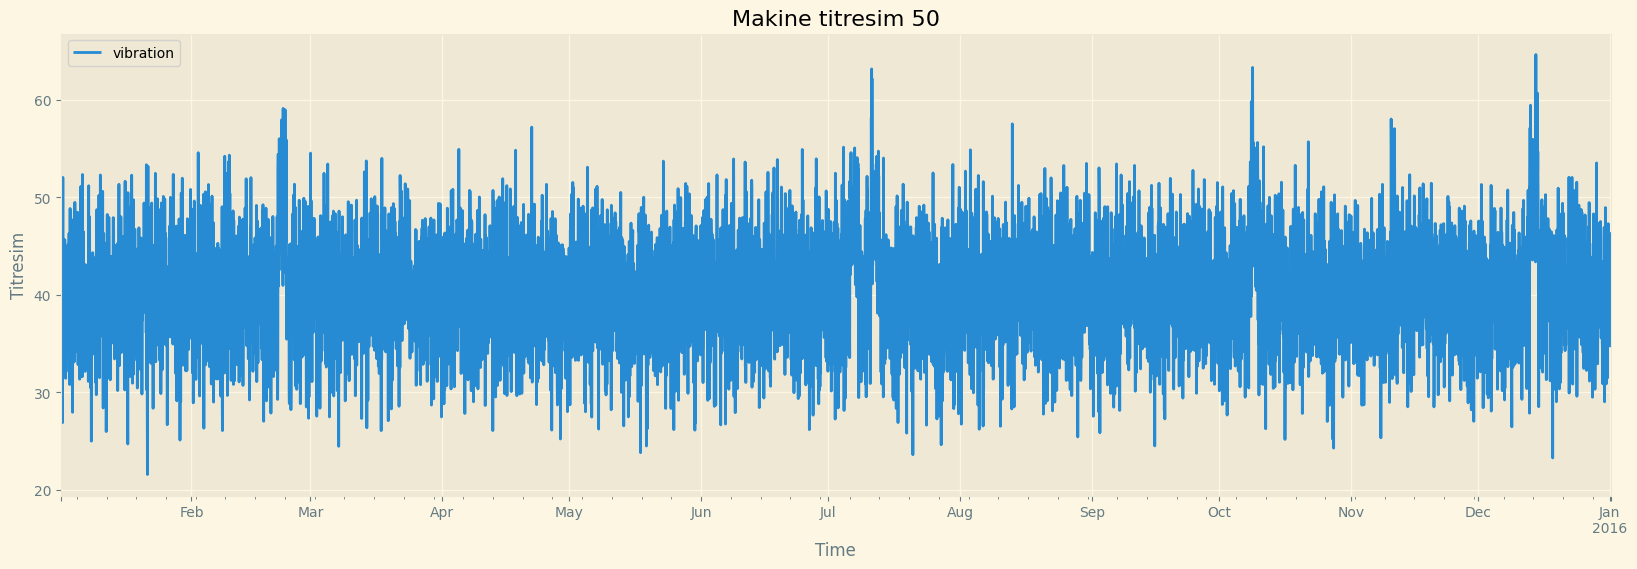

In [12]:
df_vib_machine_1 = telemetry[
    telemetry.machineID == 50][["datetime", "vibration"]].set_index("datetime")
plot_ts(df_vib_machine_1, title="Makine titresim 50", xlabel="Time", ylabel="Titresim")

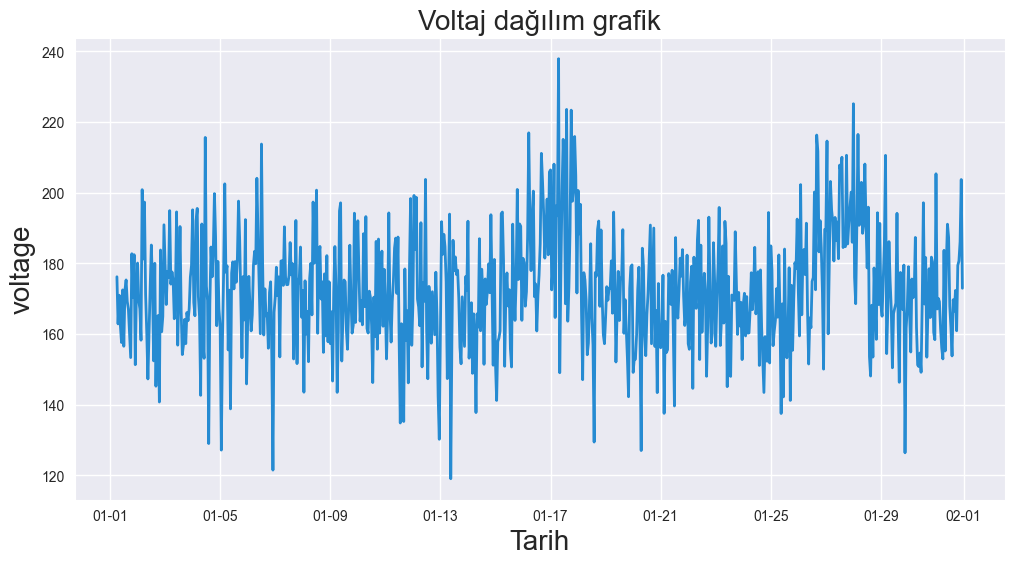

<Figure size 640x480 with 0 Axes>

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plot_df = telemetry.loc[(telemetry['machineID'] == 1) &
                        (telemetry['datetime'] > pd.to_datetime('2015-01-01')) &
                        (telemetry['datetime'] < pd.to_datetime('2015-02-01')), ['datetime', 'volt']]

sns.set_style("darkgrid")
plt.figure(figsize=(12, 6))
plt.plot(plot_df['datetime'], plot_df['volt'])
plt.ylabel('voltage',fontsize=20)

# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
adf.scaled[1.0] = '%m-%d'
plt.xlabel('Tarih',fontsize=20)
plt.title("Voltaj dağılım grafik", fontsize=20)
plt.show()
plt.savefig('voltaj_grafik.png')



In [14]:
telemetry_df = create_date_features(telemetry, telemetry, "datetime")
telemetry_df.head()

,datetime,machineID,volt,rotate,pressure,vibration,year,month,quarter,weekofyear,...,day,dayofweek,dayofyear,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,month_year
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,2015,1,1,1,...,1,3,1,True,False,True,False,True,False,2015-01
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,2015,1,1,1,...,1,3,1,True,False,True,False,True,False,2015-01
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,2015,1,1,1,...,1,3,1,True,False,True,False,True,False,2015-01
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,2015,1,1,1,...,1,3,1,True,False,True,False,True,False,2015-01
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,2015,1,1,1,...,1,3,1,True,False,True,False,True,False,2015-01


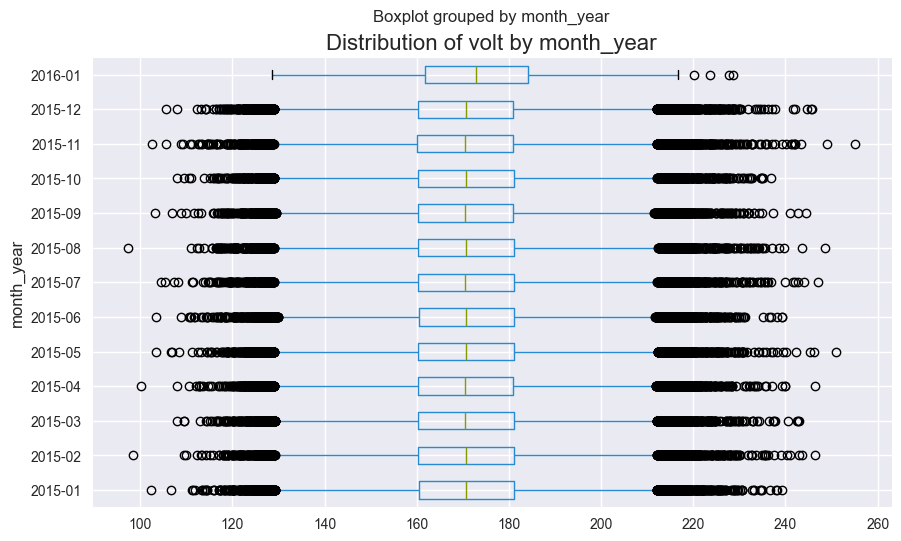

In [15]:
plot_boxh_groupby(telemetry, feature_name="volt", by="month_year")

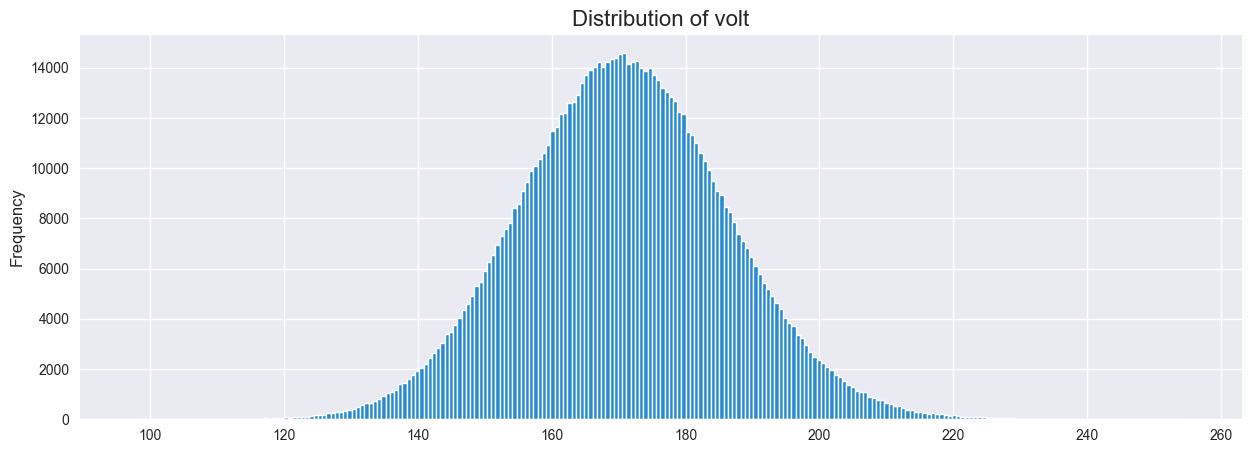

In [16]:
sns.set_style("darkgrid")
plot_hist(telemetry, feature_name="volt", log=False, bins=250)

In [17]:
#Anderson-Darling testi, bir veri kümesinin normal dağılıma uyma derecesini değerlendirmek için kullanılan bir istatistiksel testtir.
from scipy.stats import anderson
data_volt = telemetry_df['volt']
result = anderson(data_volt)
print(result)
print("#"*77)
print('result.statistic: %.3f' % result.statistic)

for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

AndersonResult(statistic=61.56284168804996, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=170.77773639409241, scale=15.509114206502083)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
#############################################################################
result.statistic: 61.563
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


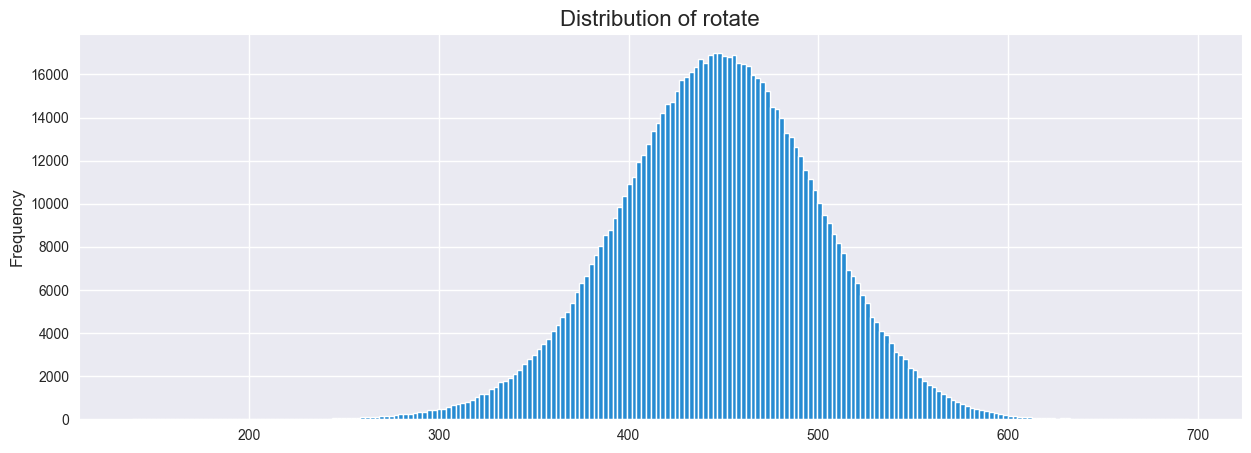

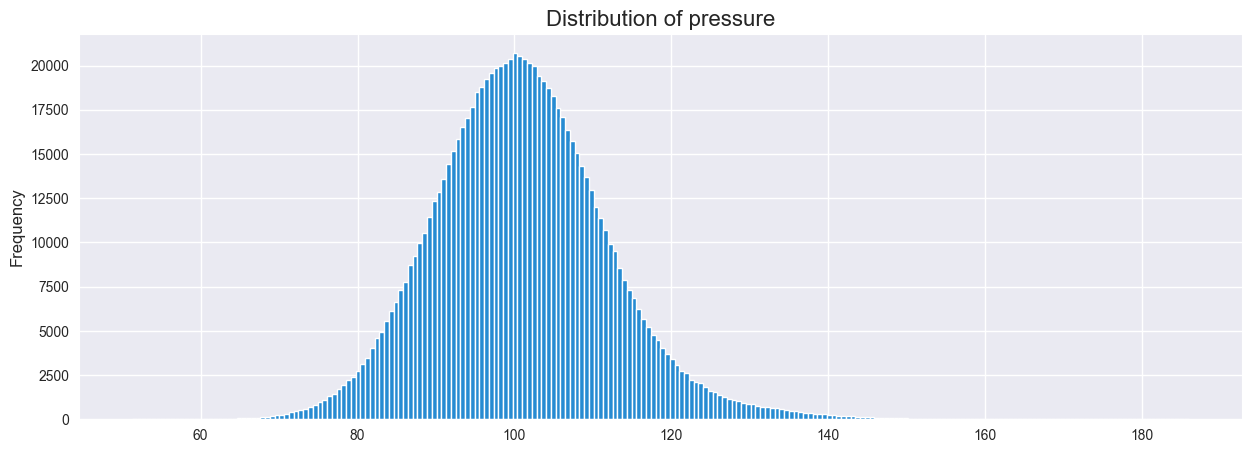

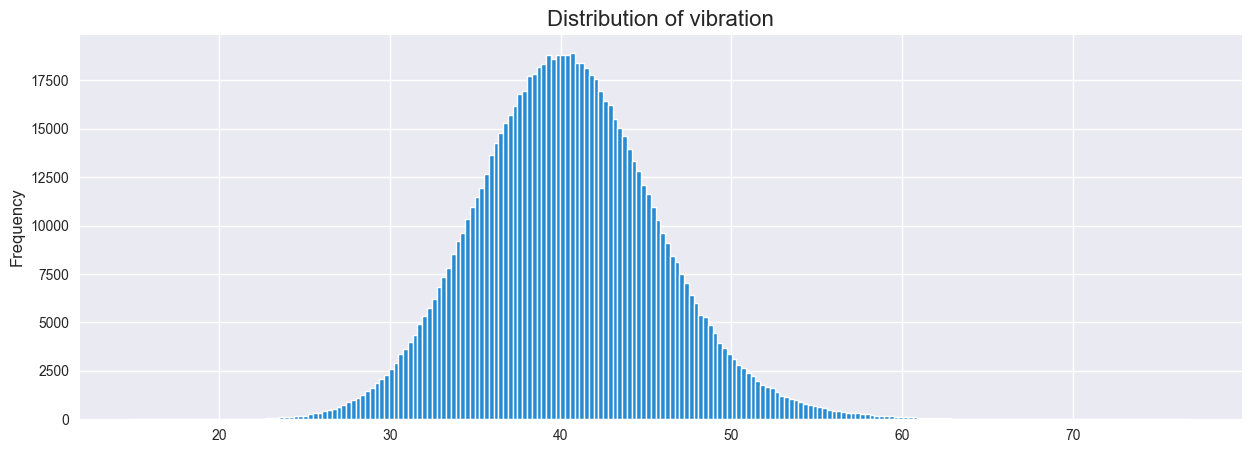

In [18]:
for name in ['rotate', 'pressure', 'vibration']:
    plot_hist(telemetry, feature_name=name, log=False, bins=222)

### Errors Data (PdM_errors.csv)
Makinelerin çalışır durumdayken karşılaştığı hatalar.

In [19]:
errors['datetime'] = pd.to_datetime(errors['datetime'], format="%Y-%m-%d %H:%M:%S")
errors['errorID'] = errors['errorID'].astype('category')

print("Toplam error sayisi: %d" % len(errors.index))
print(errors.head())
print()





Toplam error sayisi: 3919
             datetime  machineID errorID
0 2015-01-03 07:00:00          1  error1
1 2015-01-03 20:00:00          1  error3
2 2015-01-04 06:00:00          1  error5
3 2015-01-10 15:00:00          1  error4
4 2015-01-22 10:00:00          1  error4



In [20]:
check_duplicate(errors, ['datetime', 'machineID', 'errorID']) #Yineleyen değer kontrolü 

0

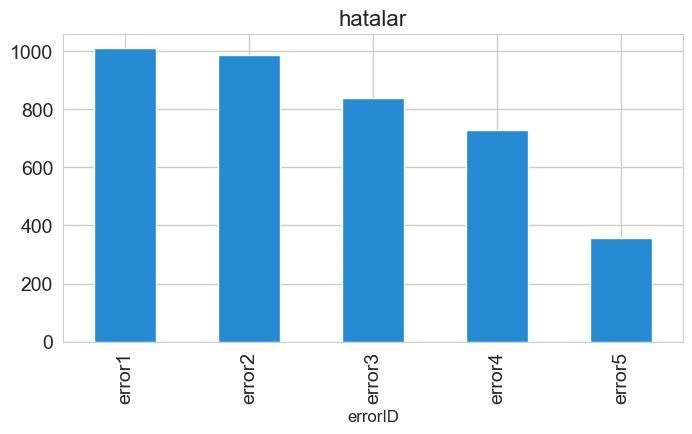

In [21]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 4))
errors['errorID'].value_counts().plot(kind='bar', fontsize=14)
plt.title("hatalar", fontsize=16)
plt.ylabel('', fontsize=14)
plt.show()


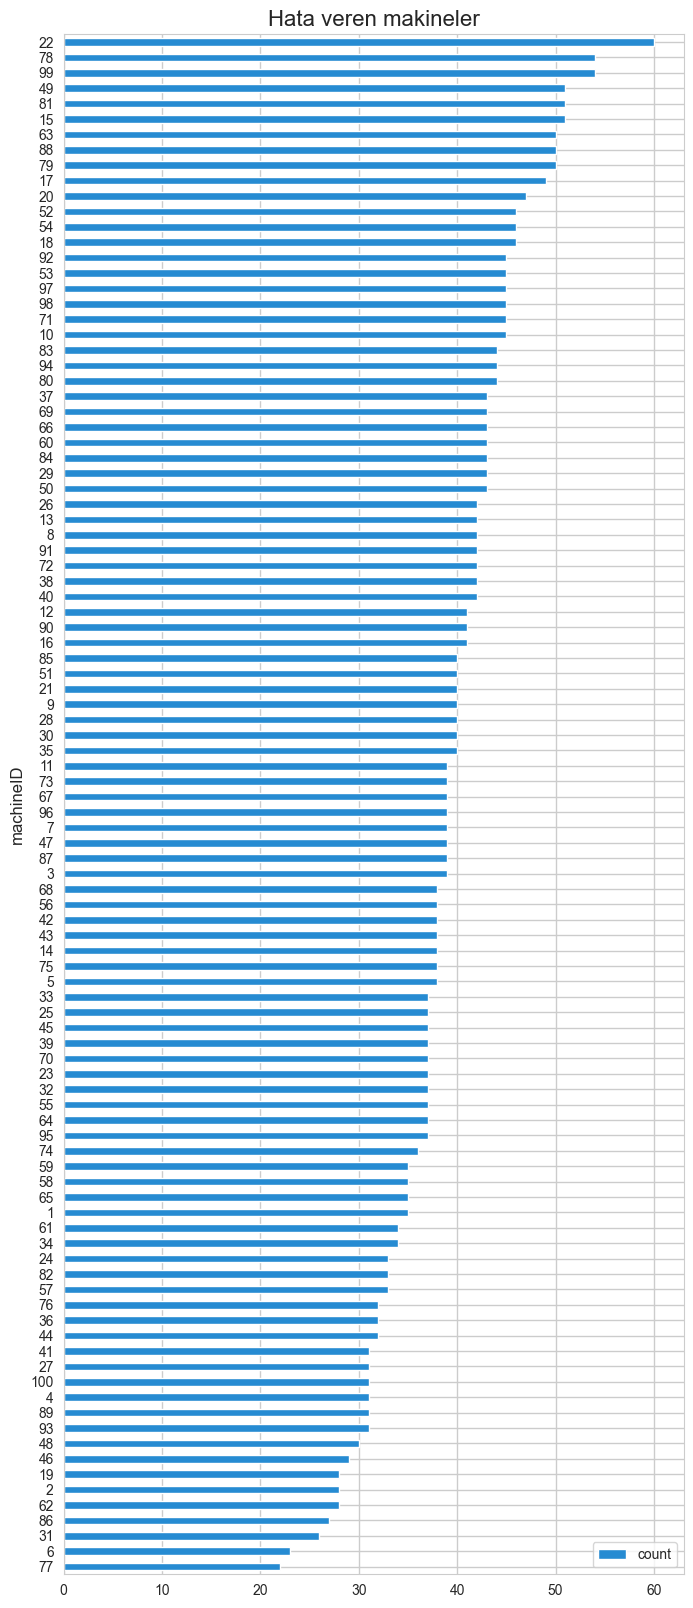

In [22]:
plot_barh(errors, "machineID", figsize=(8, 20), normalize=False,\
          title="Hata veren makineler")

C:\Users\admin\AppData\Local\Temp\ipykernel_14316\1103716874.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_errors = errors.groupby(["machineID", "errorID"]).size().reset_index()


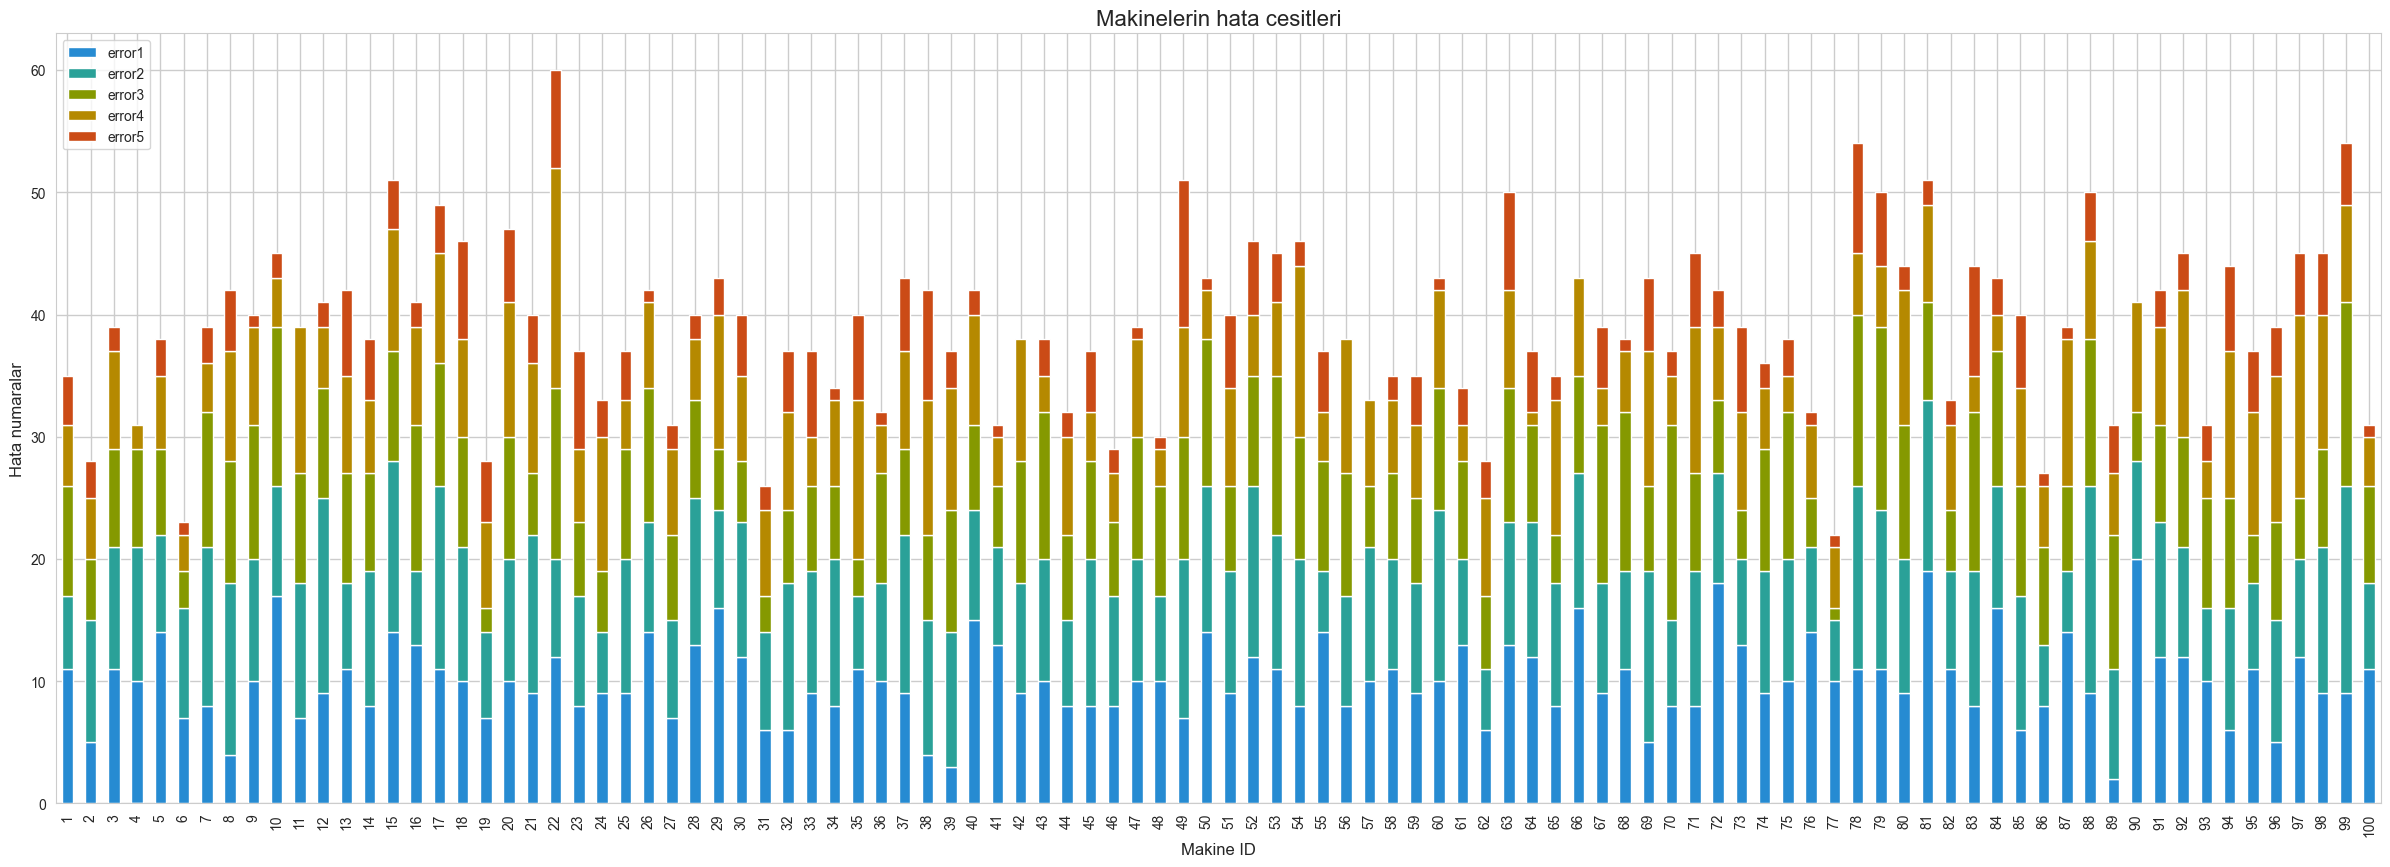

In [23]:
df_errors = errors.groupby(["machineID", "errorID"]).size().reset_index()
df_errors.columns = ["machineID", "errorID", "errorValues"]

df_errors_pivot = pd.pivot(df_errors, index="machineID", columns="errorID", \
                           values="errorValues").rename_axis(None, axis=1)

df_errors_pivot.plot.bar(stacked=True, figsize=(30, 10), \
                         title="Makinelerin hata cesitleri")

plt.xlabel("Makine ID")
plt.ylabel("Hata numaralar")
plt.show()

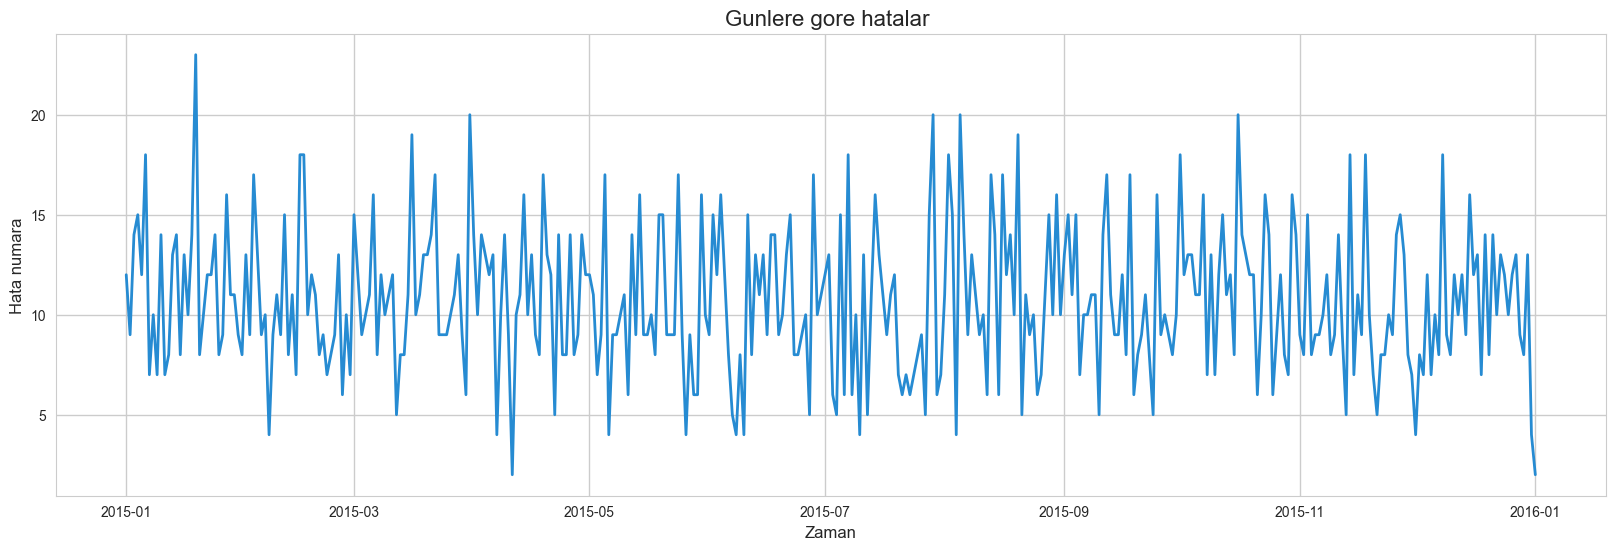

In [24]:
plot_ts(
    errors.datetime.dt.date.value_counts().sort_index(), 
    figsize=(20, 6), 
    title="Gunlere gore hatalar ", 
    xlabel="Zaman",
    ylabel="Hata numara")

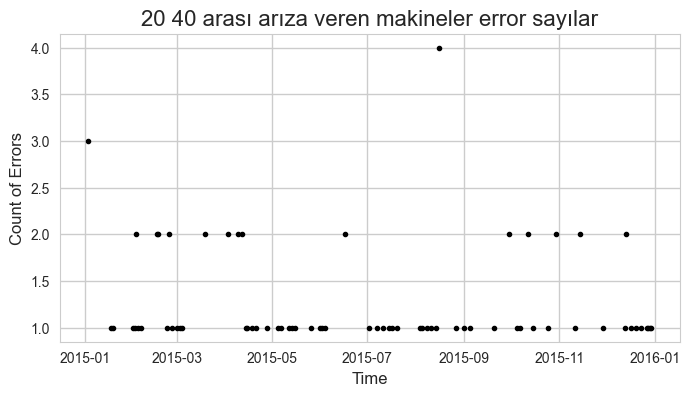

In [25]:
df_temp = errors[errors.machineID.isin([20, 40])].datetime.dt.date.value_counts().sort_index()
df_temp.plot(style="k.", figsize=(8, 4), title="20 40 arası arıza veren makineler error sayılar")
plt.ylabel("Count of Errors")
plt.xlabel("Time")
plt.show()

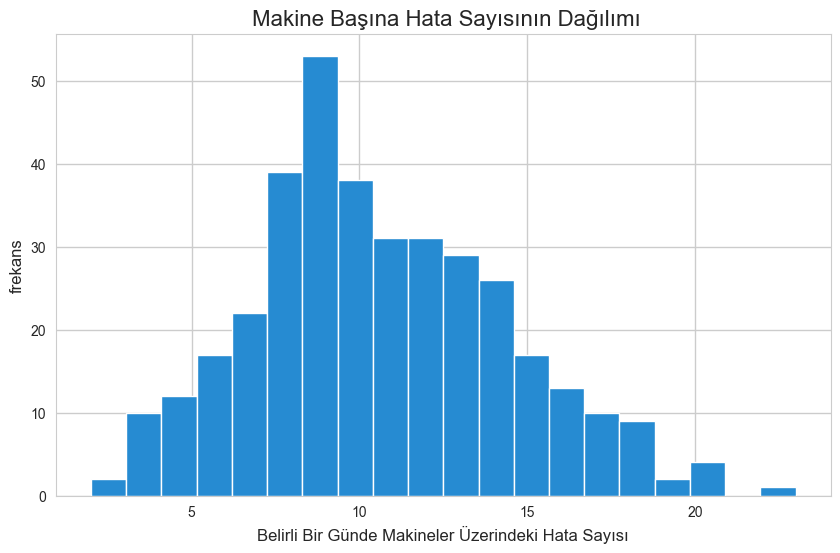

In [28]:
errors['date'] = errors.datetime.dt.date

errors.groupby('date').size().hist(bins=20, figsize=(10, 6))
plt.title(" Makine Başına Hata Sayısının Dağılımı")
plt.xlabel("Belirli Bir Günde Makineler Üzerindeki Hata Sayısı")
plt.ylabel("frekans")
plt.show()

###  Maintenance Data (PdM_maint.csv)


In [29]:
maint['datetime'] = pd.to_datetime(maint['datetime'], format="%Y-%m-%d %H:%M:%S")
maint['comp'] = maint['comp'].astype('category')

print("Toplam kayıt: %d" % len(maint.index))
maint.head()

Toplam kayıt: 3286


,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


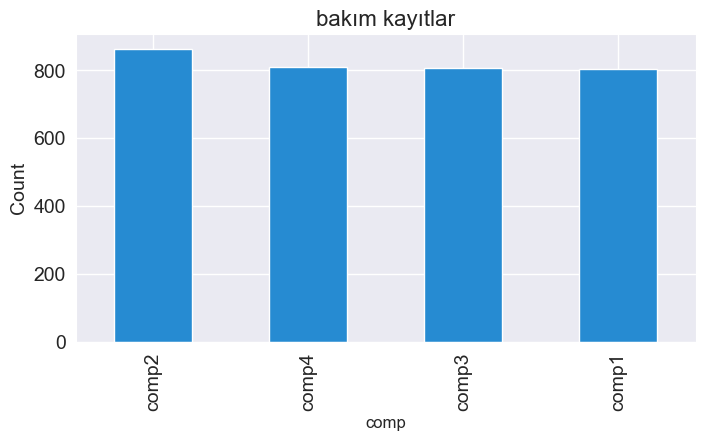

In [30]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
maint['comp'].value_counts().plot(kind='bar',fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title("bakım kayıtlar", fontsize=16)
plt.show()

In [31]:
for name in ["machineID", "comp"]:
    maint[name] = maint[name].astype("category")
    
maint.sort_values(["datetime", "machineID", "comp"], inplace=True)

# Add date related features.
maint_df = create_date_features(maint, maint, "datetime")

In [34]:
    get_missing_dates(maint_df.datetime, 
                  start_date="2014-06-01 06:00:00", 
                  end_date="2016-01-01 06:00:00", 
                  freq='H')

DatetimeIndex(['2014-06-01 07:00:00', '2014-06-01 08:00:00',
               '2014-06-01 09:00:00', '2014-06-01 10:00:00',
               '2014-06-01 11:00:00', '2014-06-01 12:00:00',
               '2014-06-01 13:00:00', '2014-06-01 14:00:00',
               '2014-06-01 15:00:00', '2014-06-01 16:00:00',
               ...
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00',
               '2016-01-01 00:00:00', '2016-01-01 01:00:00',
               '2016-01-01 02:00:00', '2016-01-01 03:00:00',
               '2016-01-01 04:00:00', '2016-01-01 05:00:00'],
              dtype='datetime64[ns]', length=13523, freq=None)

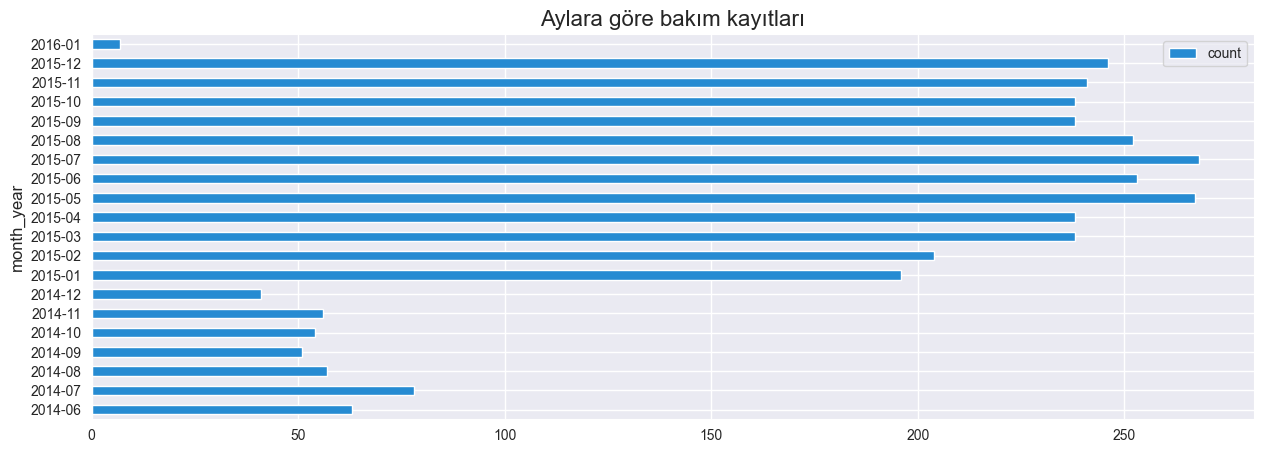

In [35]:
plot_barh(maint, "month_year", 
          normalize=False, 
          title="Aylara göre bakım kayıtları",
          sort_index=True)

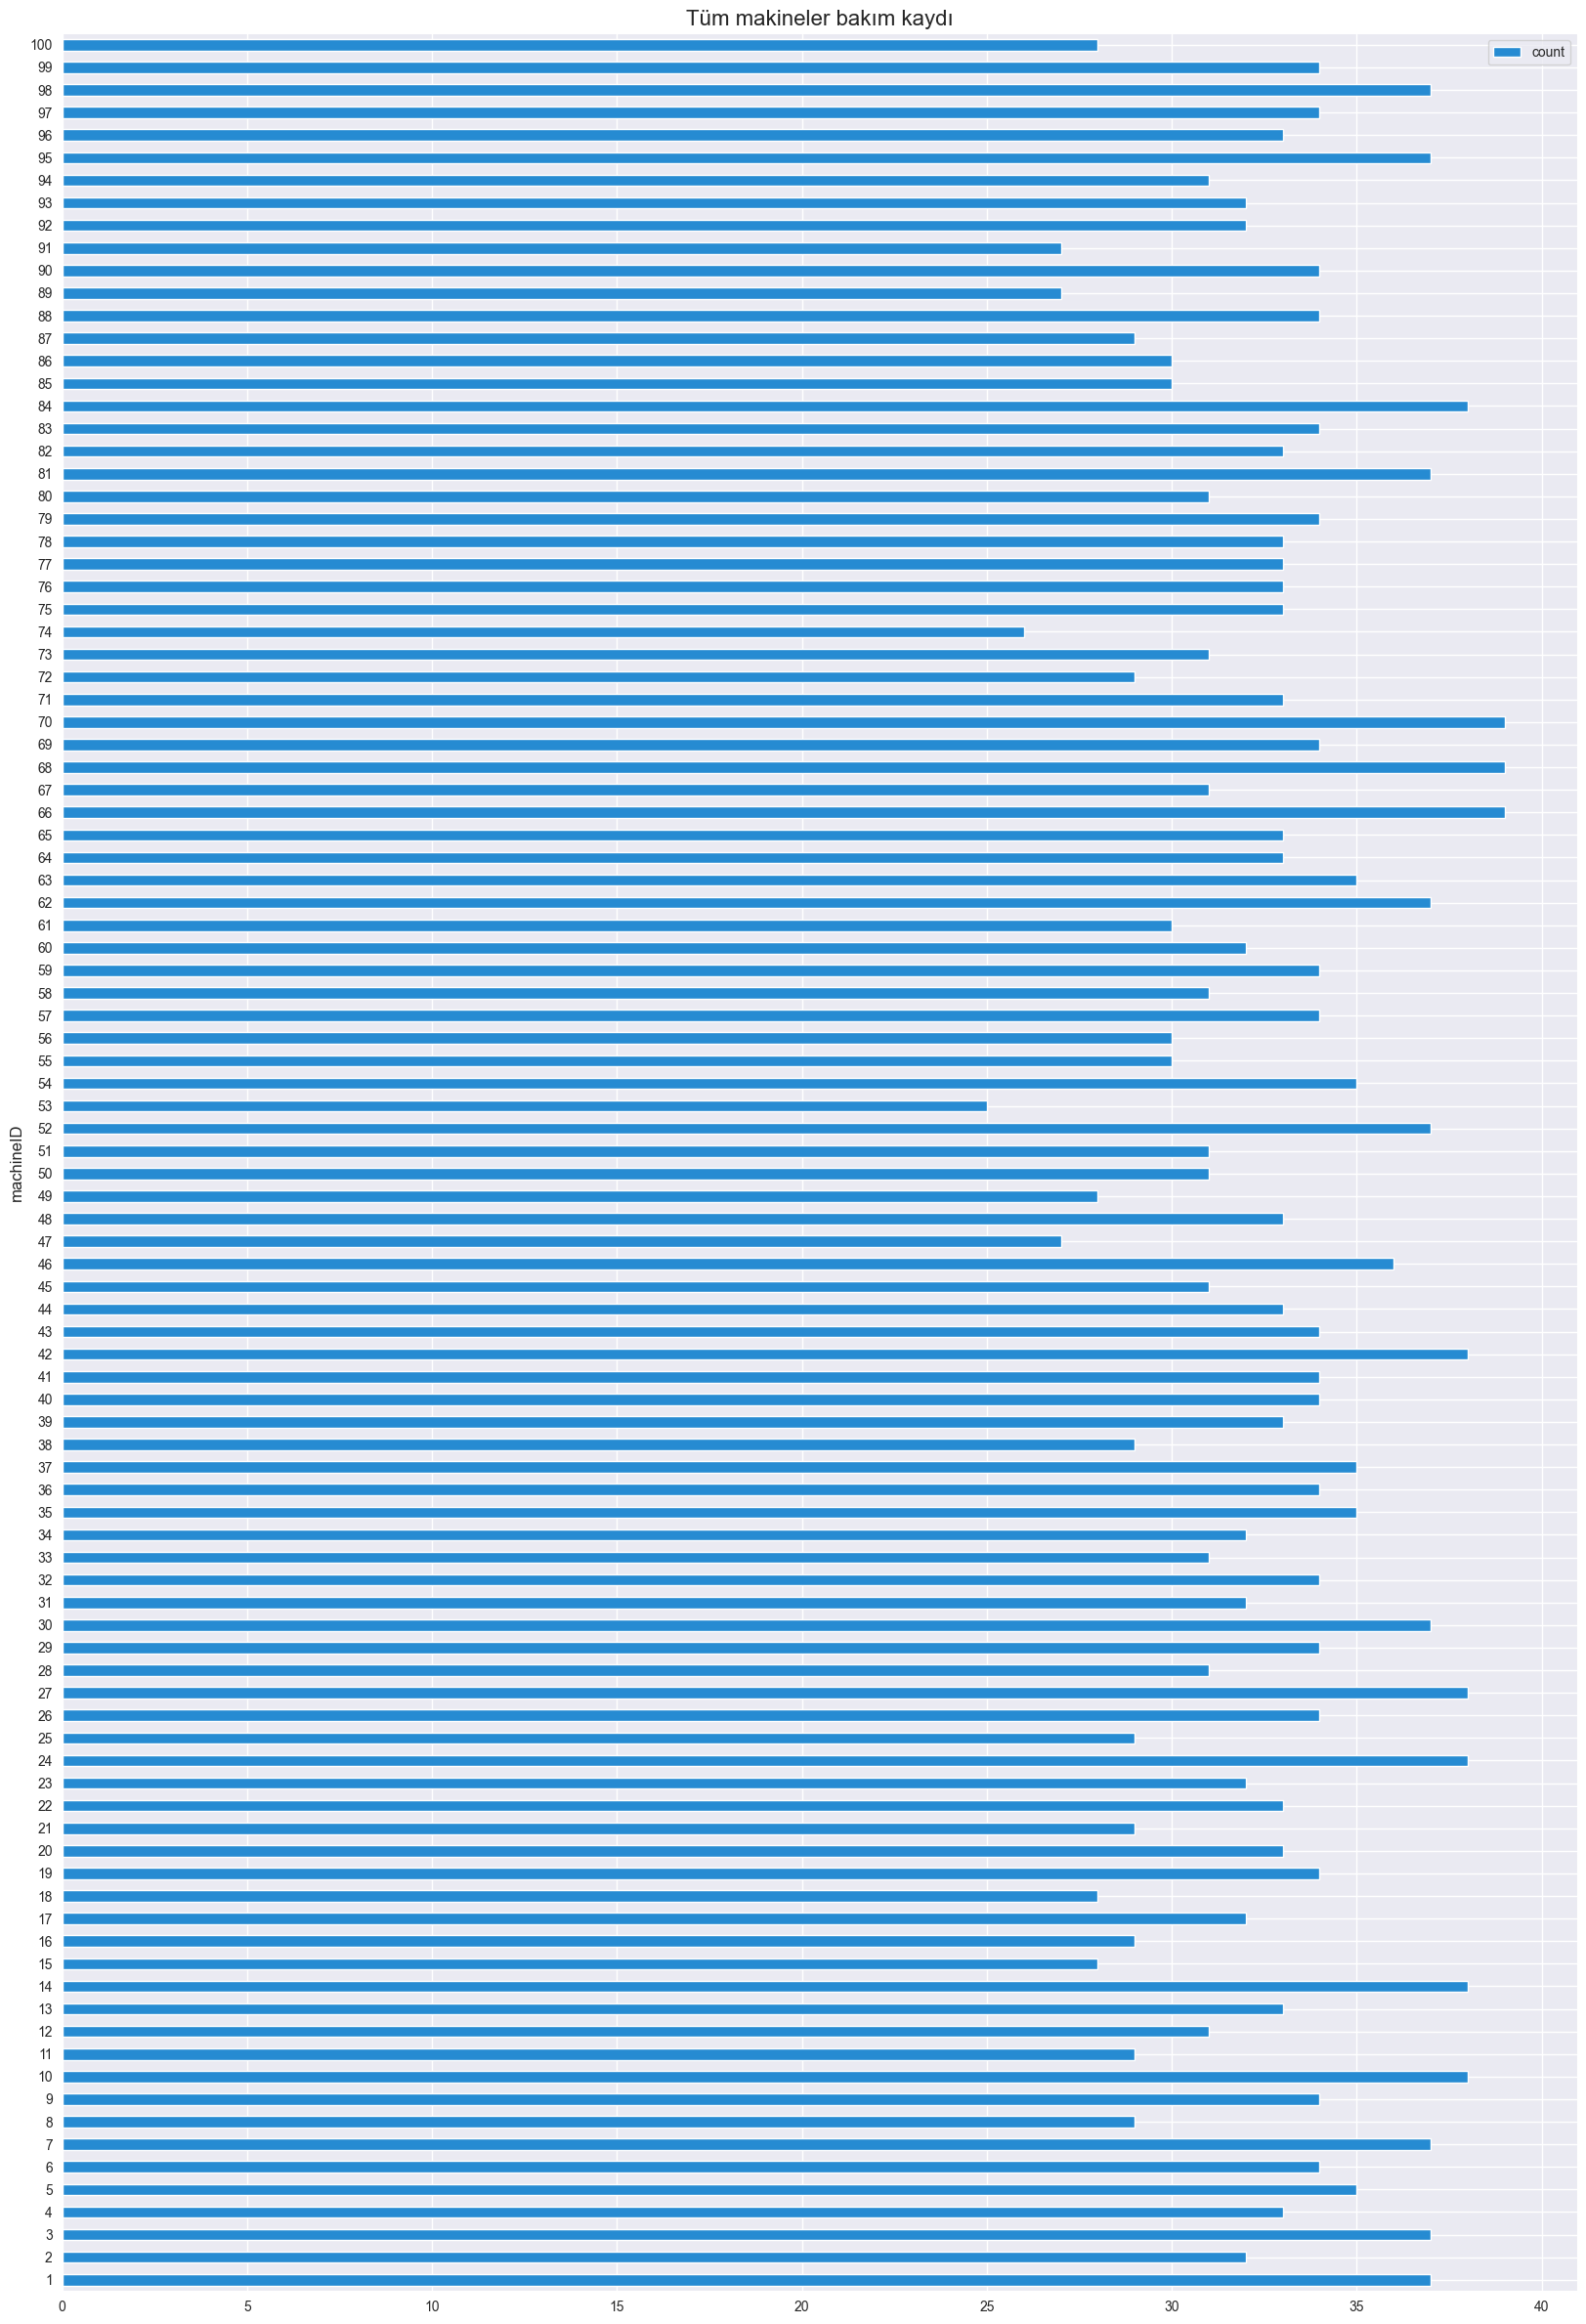

In [36]:
plot_barh(maint, "machineID", 
          figsize=(20, 30), 
          normalize=False, 
          title="Tüm makineler bakım kaydı", 
          sort_index=True)

C:\Users\admin\AppData\Local\Temp\ipykernel_14316\2156771329.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_maint = maint_df.groupby(["machineID", "comp"]).size().reset_index()


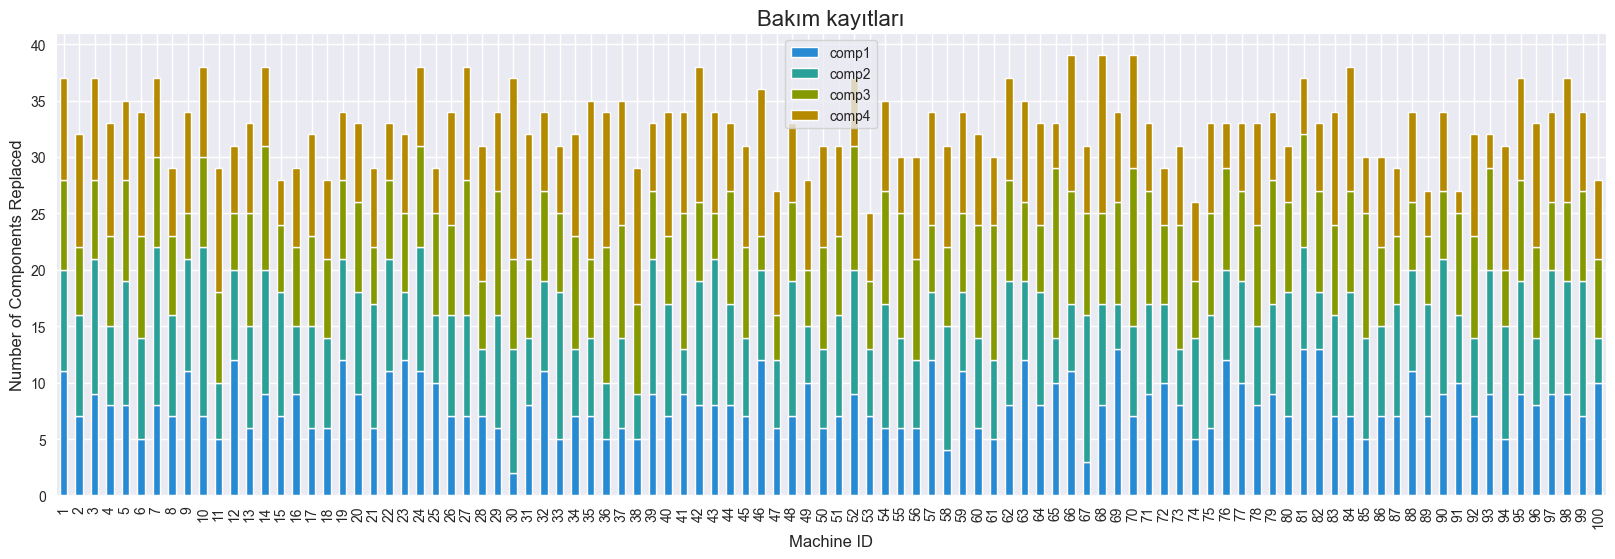

In [37]:
df_maint = maint_df.groupby(["machineID", "comp"]).size().reset_index()
df_maint.columns = ["machineID", "comp", "num_comp"]
df_maint_pivot = pd.pivot(df_maint, index="machineID", columns="comp",
                          values="num_comp").rename_axis(None, axis=1)

df_maint_pivot.plot.bar(stacked=True, figsize=(20, 6), 
                        title="Bakım kayıtları")

plt.xlabel("Machine ID")
plt.ylabel("Number of Components Replaced")
plt.show()

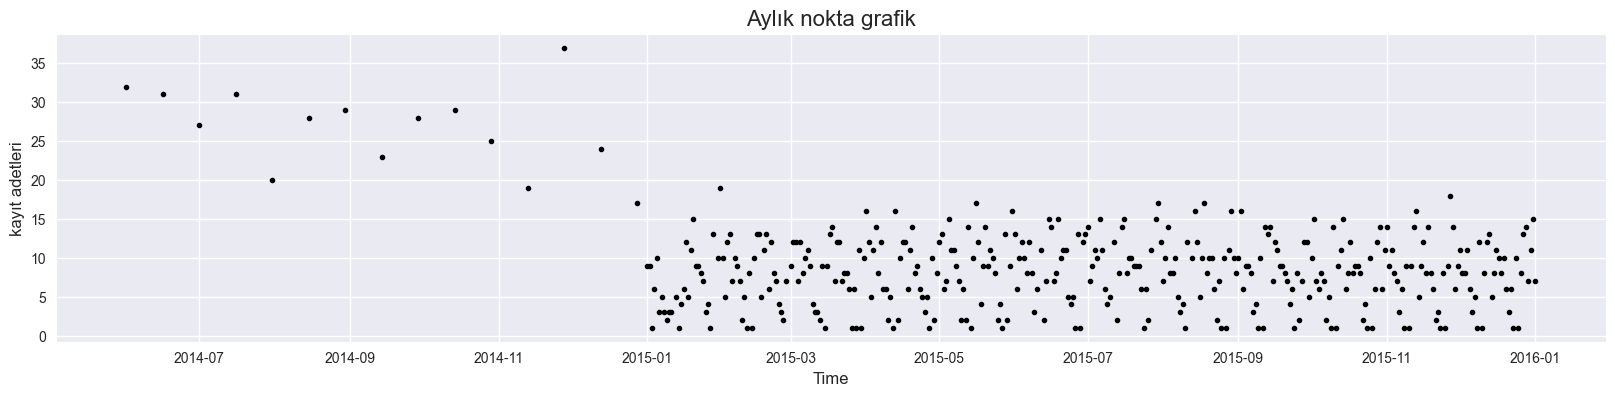

In [39]:
maint.datetime.dt.date.value_counts().plot(
    style="k.", 
    figsize=(20, 4), 
    title="Aylık nokta grafik")
plt.ylabel("kayıt adetleri")
plt.xlabel("Time")
plt.show()

### Makine Fiziksel Data (PdM_Machines.csv)

In [41]:
machines['model'] = machines['model'].astype('category')

print("Toplam makine kayıt: %d" % len(machines.index))
machines.head()

Toplam makine kayıt: 100


,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [42]:
# Makinalar Üzerindeki Hata Sayısı, Bakım Kayıtları ve Arıza Kayıtlarını İçeren Bir Veri Çerçevesi (DataFrame) 

# Makinalar arasındaki hata sayısını içeren bir DataFrame
erros_across_machine = errors.groupby("machineID").size()
erros_across_machine = pd.DataFrame(erros_across_machine, columns=["num_errors"]).reset_index()

machines_errors_df = pd.merge(machines, erros_across_machine, how='left', on="machineID")

# Makinalar arasındaki bakım kayıtlarını içeren bir DataFrame
maint_across_machine = maint.groupby("machineID").size()
maint_across_machine = pd.DataFrame(maint_across_machine, columns=["num_maint"]).reset_index()

machines_errors_df = pd.merge(machines_errors_df, maint_across_machine, how='left', on="machineID")

#M akinalar arasındaki arıza kayıtlarını içeren bir DataFrame
failure_across_machine = failures.groupby("machineID").size()
failure_across_machine = pd.DataFrame(failure_across_machine, columns=["num_failure"]).reset_index()

machines_errors_df = pd.merge(machines_errors_df, failure_across_machine, how='left', on="machineID")

machines_errors_df.head()

C:\Users\admin\AppData\Local\Temp\ipykernel_14316\2972015306.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  maint_across_machine = maint.groupby("machineID").size()


,machineID,model,age,num_errors,num_maint,num_failure
0,1,model3,18,35,37,7.0
1,2,model4,7,28,32,4.0
2,3,model3,8,39,37,5.0
3,4,model3,7,31,33,6.0
4,5,model3,2,38,35,7.0


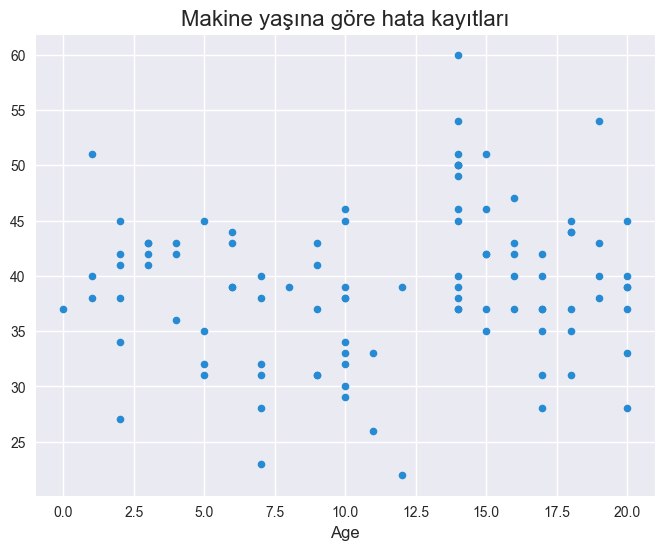

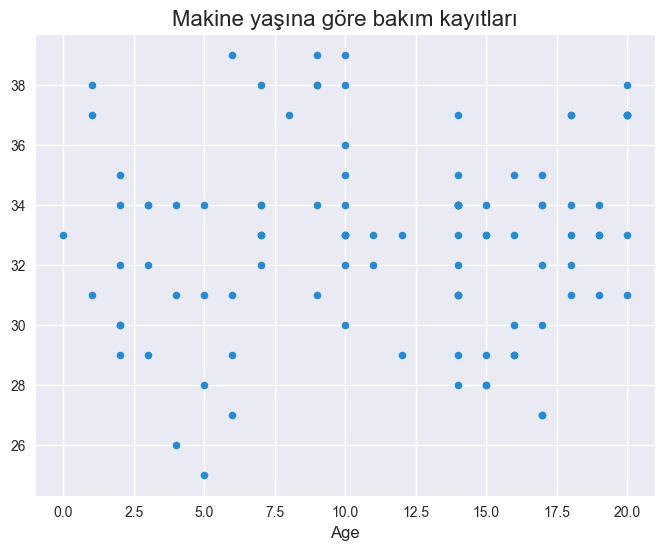

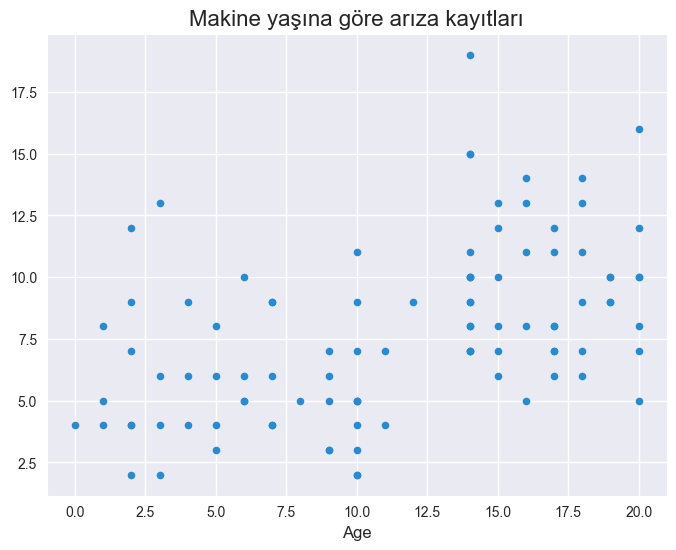

In [112]:
plot_scatter(machines_errors_df, "age", "num_errors", 
             title="Makine yaşına göre hata kayıtları", 
             xlabel="Age")

plot_scatter(machines_errors_df, "age", "num_maint", 
             title="Makine yaşına göre bakım kayıtları", 
             xlabel="Age")

plot_scatter(machines_errors_df, "age", "num_failure", 
             title="Makine yaşına göre arıza kayıtları", 
             xlabel="Age")



In [141]:
machines_errors_df.corr()

,age,num_errors,num_maint,num_failure
age,1.000000,0.106931,0.075445,0.476459
num_errors,0.106931,1.000000,-0.026558,0.483735
num_maint,0.075445,-0.026558,1.000000,-0.030258
num_failure,0.476459,0.483735,-0.030258,1.000000


###  Arızalar Data (PdM_failures.csv)


In [43]:
# Format datetime field which comes in as string.

failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['failure'] = failures['failure'].astype('category')

print("Toplam kayıt: %d" % len(failures.index))
failures.head()

Toplam kayıt: 761


,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


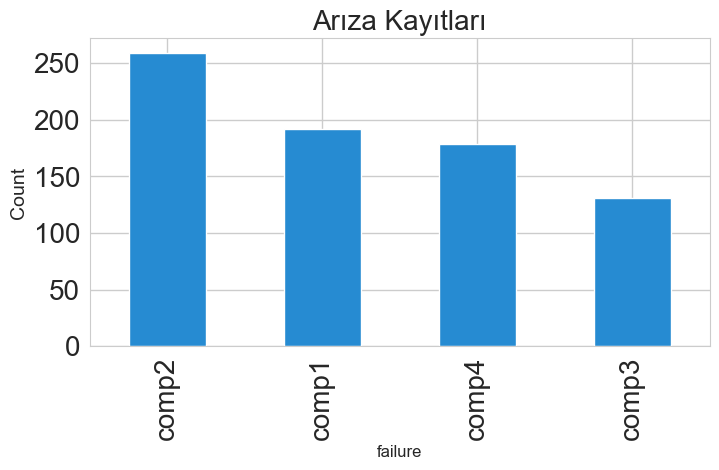

In [44]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 4))
failures['failure'].value_counts().plot(kind='bar', fontsize=20)
plt.ylabel('Count', fontsize=14)
plt.title("Arıza Kayıtları", fontsize=20)
plt.show()

### Veri Setlerinin Birleştirilmesi

In [9]:
import pandas as pd

telemetry = pd.read_csv('PdM_telemetry.csv')
errors = pd.read_csv('PdM_errors.csv')
maint = pd.read_csv('PdM_maint.csv')
failures = pd.read_csv('PdM_failures.csv')
machines = pd.read_csv('PdM_machines.csv')

In [10]:
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")

errors['datetime'] = pd.to_datetime(errors['datetime'], format="%Y-%m-%d %H:%M:%S")
errors['errorID'] = errors['errorID'].astype('category')

maint['datetime'] = pd.to_datetime(maint['datetime'], format="%Y-%m-%d %H:%M:%S")
maint['comp'] = maint['comp'].astype('category')

machines['model'] = machines['model'].astype('category')

failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['failure'] = failures['failure'].astype('category')

In [11]:
telemetry.head(2)

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973


In [12]:
errors.head(2)

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3


In [13]:
errors=pd.get_dummies(errors)
errors.head(2)

,datetime,machineID,errorID_error1,errorID_error2,errorID_error3,errorID_error4,errorID_error5
0,2015-01-03 07:00:00,1,True,False,False,False,False
1,2015-01-03 20:00:00,1,False,False,True,False,False


In [14]:
maint.head(2)

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4


In [15]:
maint=pd.get_dummies(maint)
maint.head(2)

,datetime,machineID,comp_comp1,comp_comp2,comp_comp3,comp_comp4
0,2014-06-01 06:00:00,1,False,True,False,False
1,2014-07-16 06:00:00,1,False,False,False,True


In [16]:
machines.head(2)

,machineID,model,age
0,1,model3,18
1,2,model4,7


In [17]:
machines=pd.get_dummies(machines)
machines.head(2)

,machineID,age,model_model1,model_model2,model_model3,model_model4
0,1,18,False,False,True,False
1,2,7,False,False,False,True


In [18]:
failures.head(2)

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1


In [19]:
tel_error_merge = telemetry[['datetime', 'machineID']].merge(errors, on=['machineID', 'datetime'], 
                                                         how='outer').fillna(0)

tel_error_merge.head(2)

,datetime,machineID,errorID_error1,errorID_error2,errorID_error3,errorID_error4,errorID_error5
0,2015-01-01 06:00:00,1,0,0,0,0,0
1,2015-01-01 07:00:00,1,0,0,0,0,0


In [20]:
telemetry.shape


(876100, 6)

In [21]:
tel_error_merge.shape

(876403, 7)

In [22]:
tel_maint_merge = telemetry[['datetime', 'machineID']].merge(maint, on=['machineID', 'datetime'], 
                                                         how='outer').fillna(0)

tel_maint_merge.head(2)

,datetime,machineID,comp_comp1,comp_comp2,comp_comp3,comp_comp4
0,2015-01-01 06:00:00,1,0,0,0,0
1,2015-01-01 07:00:00,1,0,0,0,0


In [23]:
tel_maint_merge.shape

(877223, 6)

In [24]:
telemetry.head(2)

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973


In [25]:
tel_maint_mac_merge = tel_maint_merge.merge(machines, on=['machineID'], how='left').fillna(0)

In [26]:
tel_maint_mac_merge.head(2)

,datetime,machineID,comp_comp1,comp_comp2,comp_comp3,comp_comp4,age,model_model1,model_model2,model_model3,model_model4
0,2015-01-01 06:00:00,1,0,0,0,0,18,False,False,True,False
1,2015-01-01 07:00:00,1,0,0,0,0,18,False,False,True,False


In [28]:
tel_fail_merge = telemetry[['datetime', 'machineID']].merge(failures, on=['machineID', 'datetime'], 
                                                         how='left')

tel_fail_merge.head(2)

,datetime,machineID,failure
0,2015-01-01 06:00:00,1,NaN
1,2015-01-01 07:00:00,1,NaN


In [29]:
tel_fail_merge.shape

(876142, 3)

In [30]:
final_df = telemetry.merge(tel_error_merge, on=['datetime', 'machineID'], how='left')
final_df = final_df.merge(tel_maint_mac_merge, on=['datetime', 'machineID'], how='left')
final_df = final_df.merge(tel_fail_merge, on=['datetime', 'machineID'], how='left')

In [32]:
final_df.head(2)

,datetime,machineID,volt,rotate,pressure,vibration,errorID_error1,errorID_error2,errorID_error3,errorID_error4,...,comp_comp1,comp_comp2,comp_comp3,comp_comp4,age,model_model1,model_model2,model_model3,model_model4,failure
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,0,0,0,0,...,0,0,0,0,18,False,False,True,False,NaN
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,0,0,0,0,...,0,0,0,0,18,False,False,True,False,NaN


In [33]:
final_df['failure'] = final_df['failure'].astype('str')
final_df.replace({'nan': "none"}, inplace= True)

In [38]:
final_df['errorID_error1'] = final_df['errorID_error1'].astype(int)
final_df['errorID_error2'] = final_df['errorID_error2'].astype(int)
final_df['errorID_error3'] = final_df['errorID_error3'].astype(int)
final_df['errorID_error4'] = final_df['errorID_error4'].astype(int)
final_df['errorID_error5'] = final_df['errorID_error5'].astype(int)
final_df['comp_comp1'] = final_df['comp_comp1'].astype(int)
final_df['comp_comp2'] = final_df['comp_comp2'].astype(int)
final_df['comp_comp3'] = final_df['comp_comp3'].astype(int)
final_df['comp_comp4'] = final_df['comp_comp4'].astype(int)
final_df['model_model1'] = final_df['model_model1'].astype(int)
final_df['model_model2'] = final_df['model_model2'].astype(int)
final_df['model_model3'] = final_df['model_model3'].astype(int)
final_df['model_model4'] = final_df['model_model4'].astype(int)


In [40]:
final_df.head(2)

,datetime,machineID,volt,rotate,pressure,vibration,errorID_error1,errorID_error2,errorID_error3,errorID_error4,...,comp_comp1,comp_comp2,comp_comp3,comp_comp4,age,model_model1,model_model2,model_model3,model_model4,failure
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,0,0,0,0,...,0,0,0,0,18,0,0,1,0,none
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,0,0,0,0,...,0,0,0,0,18,0,0,1,0,none


In [41]:
final_df.to_csv('final_df_first_cut.csv')

In [49]:
final_df = pd.read_csv('final_df_first_cut.csv')
final_df.head(5)

,Unnamed: 0,datetime,machineID,volt,rotate,pressure,vibration,errorID_error1,errorID_error2,errorID_error3,...,comp_comp1,comp_comp2,comp_comp3,comp_comp4,age,model_model1,model_model2,model_model3,model_model4,failure
0,0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,0,0,0,...,0,0,0,0,18,0,0,1,0,none
1,1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,0,0,0,...,0,0,0,0,18,0,0,1,0,none
2,2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,0,0,0,...,0,0,0,0,18,0,0,1,0,none
3,3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,0,0,0,...,0,0,0,0,18,0,0,1,0,none
4,4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,0,0,0,...,0,0,0,0,18,0,0,1,0,none


In [54]:
data = final_df.drop(['datetime', 'machineID', 'failure'], axis=1)
data.head(2)

,Unnamed: 0,volt,rotate,pressure,vibration,errorID_error1,errorID_error2,errorID_error3,errorID_error4,errorID_error5,comp_comp1,comp_comp2,comp_comp3,comp_comp4,age,model_model1,model_model2,model_model3,model_model4
0,0,176.217853,418.504078,113.077935,45.087686,0,0,0,0,0,0,0,0,0,18,0,0,1,0
1,1,162.879223,402.747490,95.460525,43.413973,0,0,0,0,0,0,0,0,0,18,0,0,1,0


In [55]:
labels=final_df['failure']
labels.head(2)

0    none
1    none
Name: failure, dtype: object

In [56]:
labels.unique()

array(['none', 'comp4', 'comp1', 'comp2', 'comp3'], dtype=object)

In [57]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(data)
print(standardized_data.shape)

(877209, 19)


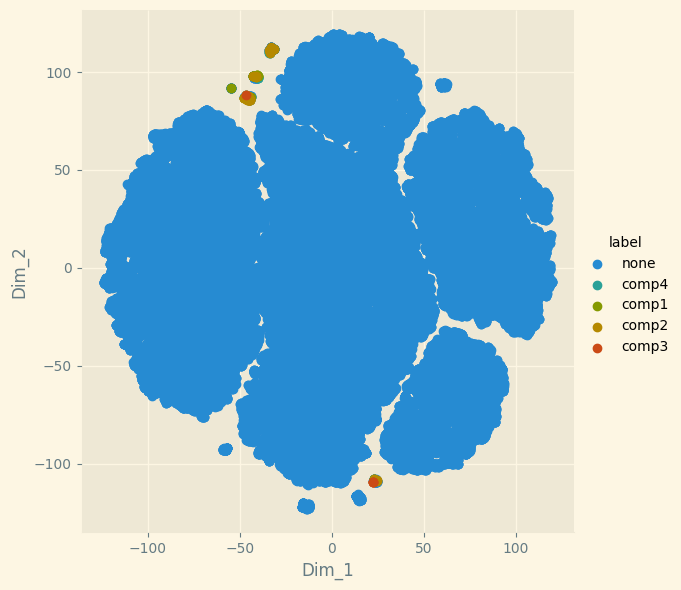

In [60]:
from sklearn.manifold import TSNE
import seaborn as sns


# Picking the top 1,00,000 points as TSNE takes a lot of time for 8,77,209 points
data_100000 = standardized_data[0:100000,:]
labels_100000 = labels[0:100000]

model = TSNE(n_components=2, random_state=0,  n_jobs=-1)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_100000)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_100000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend(title='label')
plt.show()

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.007s...
[t-SNE] Computed neighbors for 100000 samples in 15.591s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional proba

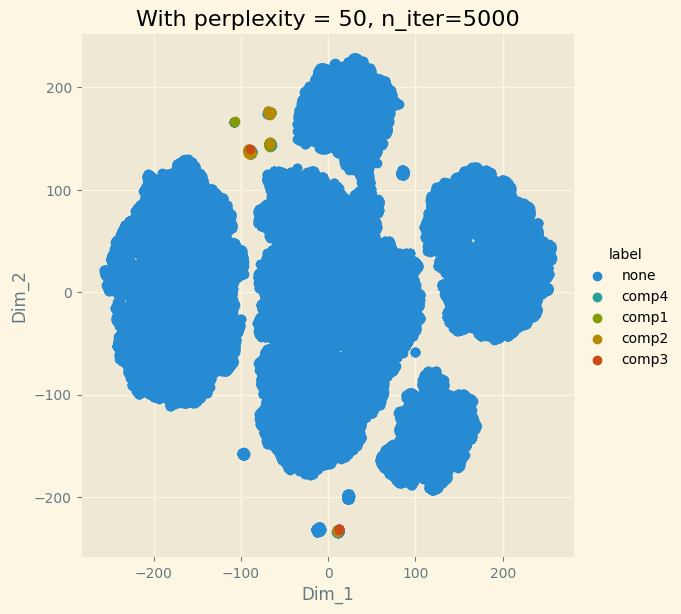

In [62]:
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=5000, n_jobs=-1, verbose=2)
tsne_data = model.fit_transform(data_100000) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_100000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend(title='label')
plt.title('With perplexity = 50, n_iter=5000')
plt.show()